In this notebook, I continue modeling and zero in on a final setup. I also further explore the options that LIME offers for visuals.

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt         
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline
from tensorflow.keras import models, layers, regularizers, Input
plt.rcParams["axes.grid"] = False
import keras

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

In [3]:
def model_plots(history,name):
    plt.style.use('ggplot')
    
    fig1, ax1 = plt.subplots(figsize=(6,6))
    metrics = ['acc','val_acc']
    for metric in metrics:
        ax1 = plt.plot(history.history[metric], label=metric)
    ax1 = plt.title(f'{name}-Accuracy')

    ax1 = plt.legend()
    ax1 = plt.tight_layout()
    ax1 = plt.xlabel('Epochs')
    ax1 = plt.ylabel('Accuracy')
    fig1.savefig(f'Images/metrics/{name}-accuracy.jpg',bbox_inches='tight', dpi=150)
    
    fig2, ax2 = plt.subplots(figsize=(6,6))
    metrics = ['loss','val_loss']
    for metric in metrics:
        ax2 = plt.plot(history.history[metric], label=metric)
    ax2 = plt.title(f'{name}-Loss')

    ax2 = plt.legend()
    ax2 = plt.tight_layout()
    ax2 = plt.xlabel('Epochs')
    ax2 = plt.ylabel('Loss')
    fig2.savefig(f'Images/metrics/{name}-loss.jpg',bbox_inches='tight', dpi=150)

Josh sent me the color compressed images that he was working on. Here, I load them and then resize them to fit in the final model.

In [4]:
test_clustered = np.load('../../../../Datasets/clusted_images_test.npz')['args']
train_clustered = np.load('../../../../Datasets/clusted_images_train.npz')['args']
test_clustered_labels = np.load('../../../../Datasets/test_labels.npz')['args']
train_clustered_labels = np.load('../../../../Datasets/train_labels.npz')['args']

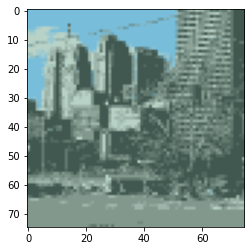

In [5]:
#here is an example. Notice the washed-out look
plt.imshow(cv2.resize(test_clustered[1],(75,75)))

In [6]:
test_clustered.shape

(3000, 150, 150, 3)

In [7]:

test_clustered_reshaped = np.full((3000,75,75,3),None)
for i in range(0,3000,1):
    test_clustered_reshaped[i] = cv2.resize(test_clustered[1],(75,75))

In [8]:
test_clustered_reshaped.shape

(3000, 75, 75, 3)

In [11]:
#reshaping
def reshaper(array_of_imgs,height,width):
    '''
    Takes an array of RGB images and the reshaped height and width as ints. Reshapes each image to the new size and returns a new array of reshaped images.
    '''
    new_shape = np.full((len(array_of_imgs),75,75,3),None)
    for i in range(0,len(array_of_imgs),1):
        new_shape[i] = cv2.resize(array_of_imgs[i],(height,width))
    return new_shape

In [12]:
test_clustered_reshaped = reshaper(test_clustered,75,75).astype('float32')
train_clustered_reshaped = reshaper(train_clustered,75,75).astype('float32')

In [13]:
test_clustered_reshaped.dtype

dtype('float32')

In [14]:
def model_plots(history,name):
    plt.style.use('ggplot')
    
    fig1, ax1 = plt.subplots(figsize=(6,6))
    metrics = ['acc','val_acc']
    for metric in metrics:
        ax1 = plt.plot(history.history[metric], label=metric)
    ax1 = plt.title(f'{name}-Accuracy')

    ax1 = plt.legend()
    ax1 = plt.tight_layout()
    ax1 = plt.xlabel('Epochs')
    ax1 = plt.ylabel('Accuracy')
    fig1.savefig(f'Images/{name}-accuracy.jpg',bbox_inches='tight', dpi=150)
    
    fig2, ax2 = plt.subplots(figsize=(6,6))
    metrics = ['loss','val_loss']
    for metric in metrics:
        ax2 = plt.plot(history.history[metric], label=metric)
    ax2 = plt.title(f'{name}-Loss')

    ax2 = plt.legend()
    ax2 = plt.tight_layout()
    ax2 = plt.xlabel('Epochs')
    ax2 = plt.ylabel('Loss')
    fig2.savefig(f'Images/{name}-loss.jpg',bbox_inches='tight', dpi=150)

In [15]:
layers_list = []

def modeler(layers_list,dims):
    
    model = models.Sequential()
    model.add(layers.InputLayer(dims))
    #     model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(75, 75, 3)))
    #     model.add(layers.Conv2D(128,(3,3),activation='relu'))

    
    for layer in layers_list:
        model.add(layer)
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(6,activation='softmax'))
    
    
 
    return model

In [16]:
def model_trainer(model,name,train_img,train_labels,test_img,test_labels,batch_size=16,epochs=5,summary=False):
    
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
    
    if summary:
        return model.summary()
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'../../../../Models/{name}_model.h5', save_best_only=True)
    earlystop = tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', # What to watch
                                min_delta=0.1, # How much change to get
                                patience=5 # No change after 5 epochs
    )
    history = model.fit(train_img,train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(test_img,test_labels),
                    callbacks=[checkpoint,earlystop])
    
    return history

In [17]:
# layers_list = [layers.Conv2D(128,(3,3),activation='relu',input_shape=(75, 75, 3)),
#                layers.MaxPooling2D(2,2),
#                layers.Dropout(0.2),
#                layers.Conv2D(128,(3,3),activation='relu',kernel_regularizer=regularizers.l2(l2=0.15))
#                ]

# model = modeler(layers_list,(75,75,3))

In [18]:
# history = model_trainer(model,'3rd-color_comp',
#                         train_clustered_reshaped,train_clustered_labels,
#                         test_clustered_reshaped,test_clustered_labels,
#                         batch_size=32,
#                         epochs=5,
#                         summary=False)

In [37]:
#loading the final model from what was trained above so that I can use LIME on it
model = tf.keras.models.load_model('../../../../Models/3rd-color_comp_model.h5')

In [38]:
#Model summary doesn't git all of the info about the model
#the config shows the regularization types and the values
model.get_config()

{'name': 'sequential_12',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 75, 75, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_13'}},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d_34',
    'trainable': True,
    'batch_input_shape': (None, 75, 75, 3),
    'dtype': 'float32',
    'filters': 128,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d_12',
    'trainable': True,
 

In [21]:
# model_plots(history,'3rd-color_comp')

In [22]:
import lime
plt.rcParams["axes.grid"] = False


In [23]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [24]:
import random

In [25]:
def image_expl(model,image_array,name,image_label):
    '''
    Takes a model, single image array, name string of the model, and the true label of the image.
    Uses LIME to get an image explainer and plots the image and explaination.
    '''
    fig, ax = plt.subplots()

    #instantiate explainer
    explainer = lime_image.LimeImageExplainer(random_state=1)
    #explain an image caste to double bc updated keras version, pass predictor 
    explanation = explainer.explain_instance(image_array.astype('double'), model.predict)
    #show the image
    plt.imshow(image_array)
    #get the mask for the prediction
    temp, mask = explanation.get_image_and_mask(model.predict(image_array.reshape((1,75,75,3))).argmax(axis=1)[0], positive_only=False, hide_rest=False)
    #show image and mask together
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis('off')

    plt.title(f'{name}-{image_label}')
    

    fig.savefig(f'Images/explainer/{name}-{image_label}.jpg',bbox_inches='tight', dpi=150)

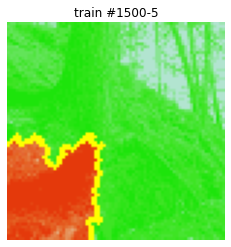

In [26]:
image_expl(model,test_clustered_reshaped[500],'train #1500',test_clustered_labels[500])

In [27]:
def image_preds(model,image_array,name,image_label):
    '''
    Takes a model, single image array, name string of the model, and the true label of the image.
    Plots the class predictions for the image.
    '''
    plt.style.use('fivethirtyeight')
    plt.rcParams["axes.grid"] = False

    fig, ax = plt.subplots(figsize=(6,6))
    ax = plt.plot(range(0,6),model.predict(image_array.reshape((1,75,75,3)))[0])
    ax = plt.xticks(ticks=[0,1,2,3,4,5],labels=class_names)
    ax = plt.tight_layout()
    ax = plt.xlabel('Class Name')
    ax = plt.ylabel('Confidence')
    ax = plt.title(f'{name}-{image_label}')
    fig.savefig(f'Images/preds/{name}-{image_label}-preds.jpg',bbox_inches='tight', dpi=150)

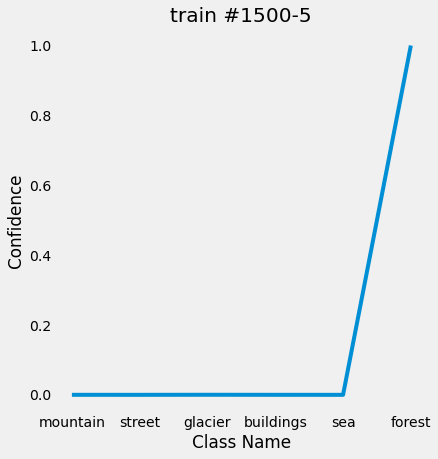

In [28]:
image_preds(model,test_clustered_reshaped[500],'train #1500',test_clustered_labels[500])

In [29]:
def plotter(img,name,label):
    fig, ax = plt.subplots()
    
    ax = plt.imshow(img)
    ax = plt.title(f'{name}-{label}')
    plt.axis('off')
    fig.savefig(f'Images/originals/{name}-{label}-preds.jpg',bbox_inches='tight', dpi=150)

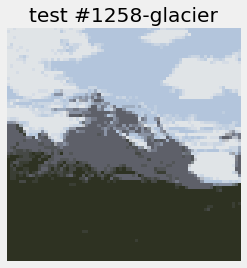

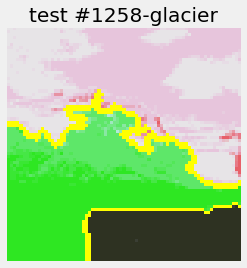

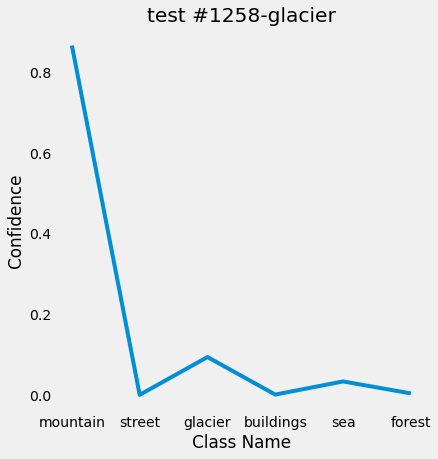

In [30]:
#Now I'm getting explainers for ten images at a time to look at. Then, I find good ones to use in the presentation.
rand_img = np.random.randint(0,3000,1)
# rand_img = [1347]
class_map = {0:'mountain',1:'street',2:'glacier',3:'buildings',4:'sea',5:'forest'}

for num in rand_img:
    label = class_map[test_clustered_labels[num]]
    plotter(test_clustered_reshaped[num],f'test #{num}',label)
    image_expl(model,test_clustered_reshaped[num],f'test #{num}',label)
    image_preds(model,test_clustered_reshaped[num],f'test #{num}',label)